## Import libraries

In [32]:
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

import sklearn
# evaluate RFE for regression
from numpy import mean
from numpy import std
#from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from xgboost import plot_importance



## Define reusable functions

#### Function for reading data from model dataset

In [3]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',', index_col=0)
    #df_data.columns=[]
    return df_data

## Read pre-processed multi-variable dataset

#### Set python variables

In [4]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data.csv"

#### Read dataset into pandas dataframe

In [5]:
# Read file
df_model_data = read_data(f'{fpath}\{fname_model_data}')

In [6]:
df_model_data

,Year,Month,temp_mean,temp_min,temp_max,demand_mean,total_consumption,demand_max,demand_mean_max,pv_capacity,population,gsp
0,2010,1,20.868008,1.6,41.1,8941.450389,6554083.135,13765.04,10613.530000,28278.392,7110454,44504.250000
1,2010,2,20.218907,3.2,35.4,8855.467677,5831325.465,13377.27,10380.667857,32153.986,7119405,44504.250000
2,2010,3,19.828286,6.3,34.7,8698.725127,6319623.805,11991.47,10132.978710,38195.588,7128356,44504.250000
3,2010,4,17.593856,6.5,29.9,8452.863411,5984627.295,11436.13,9804.072333,45142.723,7133668,44504.250000
4,2010,5,15.323485,3.1,28.4,8897.770510,6459781.390,12386.49,10558.023548,54370.332,7138980,44504.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021,8,21.104167,16.9,30.7,7368.353056,530521.420,9043.62,8410.176667,3954209.744,8091356,57391.083333
140,2021,9,20.999306,14.2,27.5,7229.393819,520516.355,9206.19,8469.680000,4033918.477,8088503,57391.083333
141,2021,10,21.084722,14.8,26.9,7209.823194,519107.270,8841.21,8575.093333,4112353.036,8092743,57391.083333
142,2021,11,22.118056,15.7,27.3,7649.492569,550763.465,9573.70,9336.970000,4192992.282,8096983,57391.083333


## Using XGBoost Regressor feature importance

In [7]:
columns_to_drop = ['Year', 'Month', 'demand_mean', 'total_consumption', 'demand_mean_max', 'demand_max']


## Split data into Response (y) and Independent (X) variable arrays

In [8]:
y_1 = df_model_data['demand_max']
y_2 = df_model_data['demand_mean']
y_3 = df_model_data['demand_mean_max']

X = df_model_data.drop(columns=columns_to_drop, axis=1, inplace=False)



In [71]:
y_3

0      10613.530000
1      10380.667857
2      10132.978710
3       9804.072333
4      10558.023548
           ...     
139     8410.176667
140     8469.680000
141     8575.093333
142     9336.970000
143     9784.833333
Name: demand_mean_max, Length: 144, dtype: float64

In [9]:
X

,temp_mean,temp_min,temp_max,pv_capacity,population,gsp
0,20.868008,1.6,41.1,28278.392,7110454,44504.250000
1,20.218907,3.2,35.4,32153.986,7119405,44504.250000
2,19.828286,6.3,34.7,38195.588,7128356,44504.250000
3,17.593856,6.5,29.9,45142.723,7133668,44504.250000
4,15.323485,3.1,28.4,54370.332,7138980,44504.250000
...,...,...,...,...,...,...
139,21.104167,16.9,30.7,3954209.744,8091356,57391.083333
140,20.999306,14.2,27.5,4033918.477,8088503,57391.083333
141,21.084722,14.8,26.9,4112353.036,8092743,57391.083333
142,22.118056,15.7,27.3,4192992.282,8096983,57391.083333


## Fit XGBoost Regression model and plot feature importance chart

In [73]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y_1)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [74]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y_1)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [75]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y_1)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [76]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

<Axes: title={'center': 'Feature importance - demand_max'}>

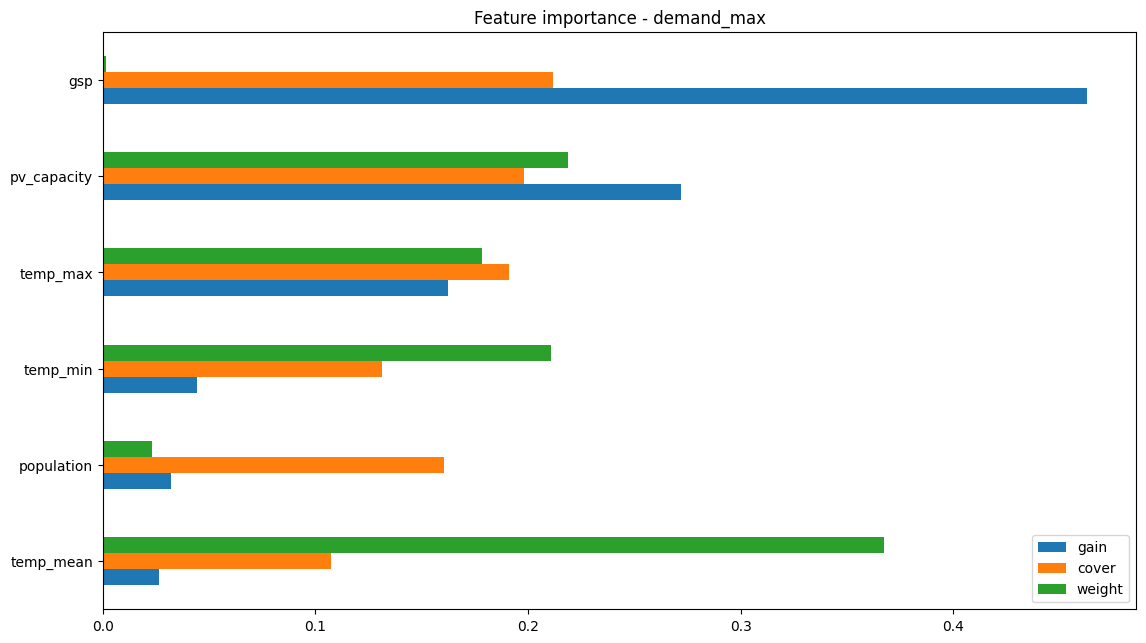

In [78]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance - demand_max')

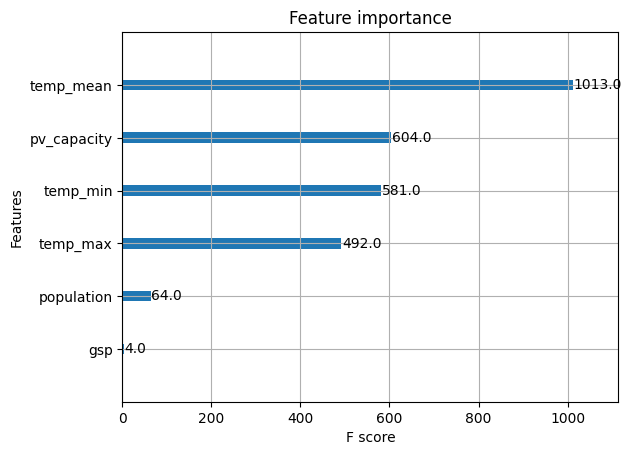

In [79]:
plot_importance(model)
plt.show()

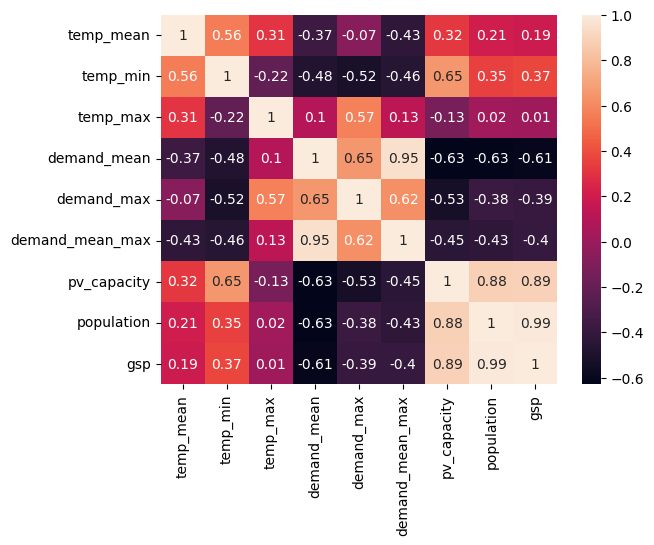

In [94]:
df_model_reduced = df_model_data.drop(['Year', 'Month', 'total_consumption'], axis=1, inplace=False)
matrix = df_model_reduced.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

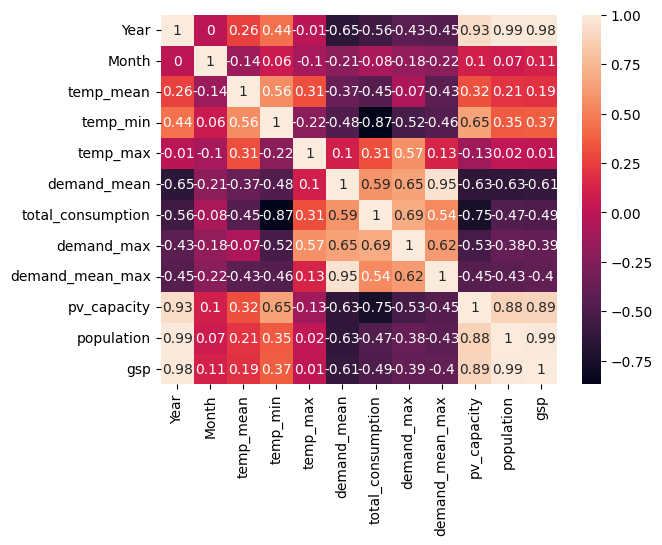

In [56]:
matrix = df_model_data.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

In [80]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y_2)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [81]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y_2)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [82]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y_2)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [83]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

<Axes: title={'center': 'Feature importance - demand_mean'}>

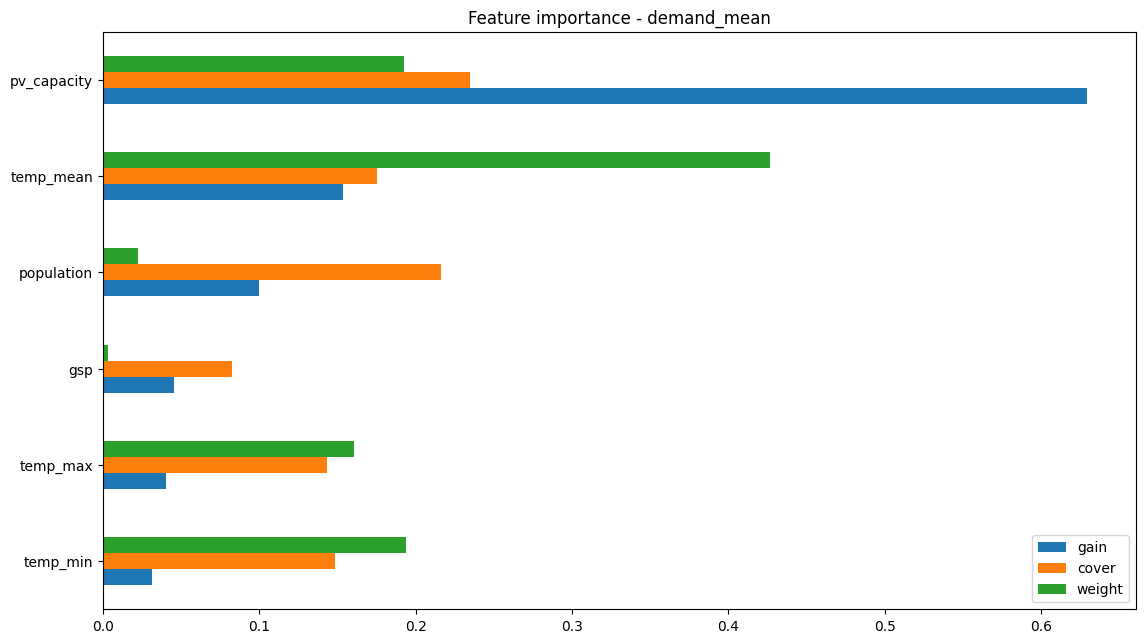

In [84]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance - demand_mean')

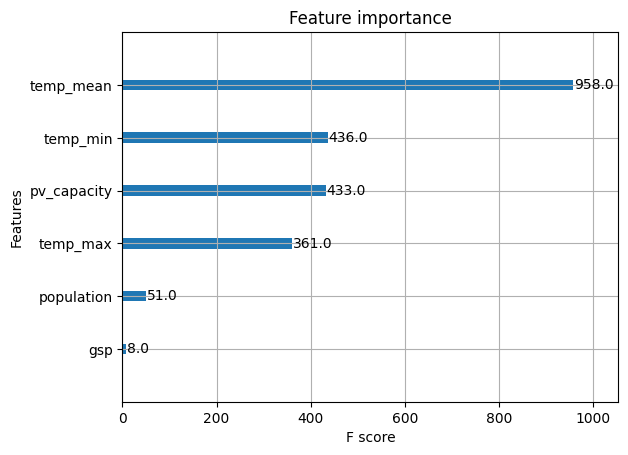

In [85]:
plot_importance(model)
plt.show()

In [86]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y_3)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [87]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y_3)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [88]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y_3)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [89]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

<Axes: title={'center': 'Feature importance - demand_mean_max'}>

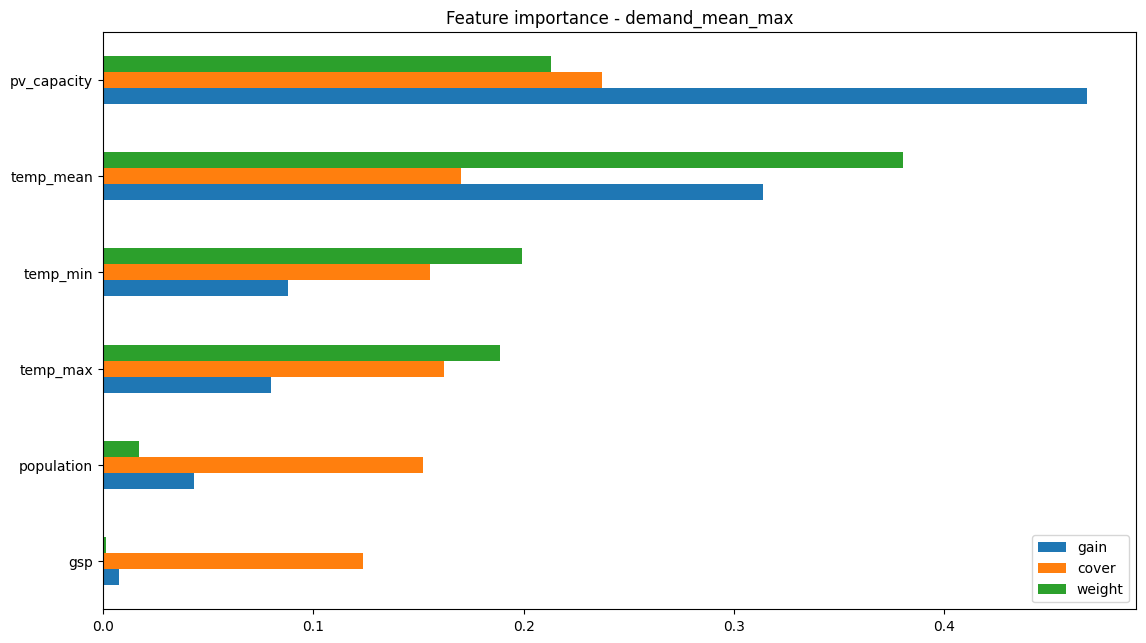

In [90]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance - demand_mean_max')

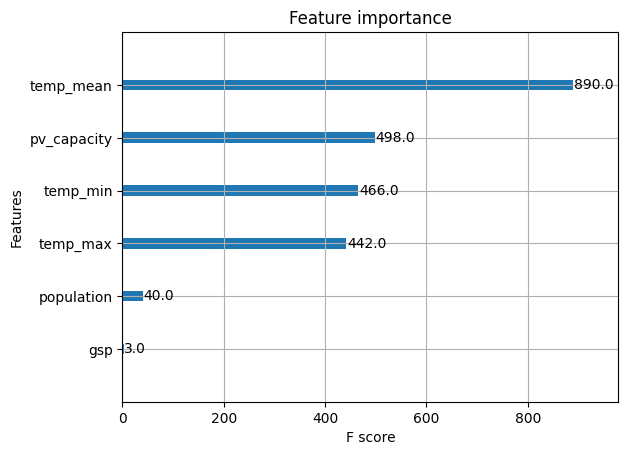

In [91]:
plot_importance(model)
plt.show()

## Using sklearn.feature_selection.RFE

In [44]:
# get a list of models to evaluate
def get_models():
 models = dict()
 # dt
 rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
 model = DecisionTreeRegressor()
 models['dt'] = Pipeline(steps=[('s',rfe),('m',model)])
 # gb
 rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=4)
 model = DecisionTreeRegressor()
 models['gb'] = Pipeline(steps=[('s',rfe),('m',model)])
 # rf
 rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=4)
 model = DecisionTreeRegressor()
 models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
 
 return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores
 

In [39]:
# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y_2, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MAE: -180.460 (36.174)


In [41]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
models

{'dt': Pipeline(steps=[('s',
                  RFE(estimator=DecisionTreeRegressor(),
                      n_features_to_select=4)),
                 ('m', DecisionTreeRegressor())]),
 'gb': Pipeline(steps=[('s',
                  RFE(estimator=GradientBoostingRegressor(),
                      n_features_to_select=4)),
                 ('m', DecisionTreeRegressor())])}

dt
>dt -273.816 (58.236)
gb
>gb -267.189 (54.603)
rf
>rf -264.111 (56.461)


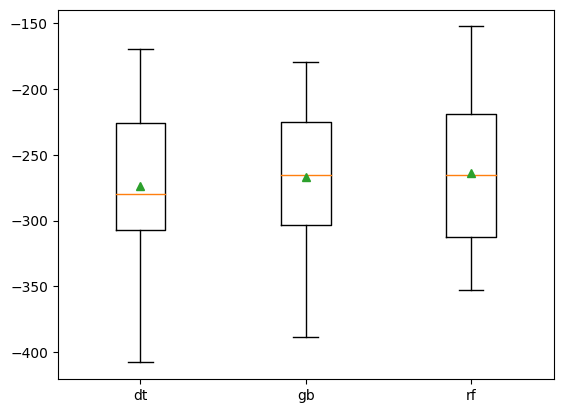

In [45]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 print(name)
 scores = evaluate_model(model, X, y_3)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [46]:
scores

array([-263.40180573, -218.16991696, -284.41037236, -330.67289949,
       -168.56777805, -266.41543142, -320.83238315, -195.09095885,
       -222.2828883 , -342.71735839, -253.94745771, -352.6789831 ,
       -287.62628301, -196.84978516, -190.60628001, -233.99586927,
       -257.90294367, -333.66012755, -210.31945293, -311.34999098,
       -273.47976702, -349.46273029, -290.22049657, -152.47901525,
       -222.57399555, -192.68346237, -264.18995731, -314.24168961,
       -309.91330575, -312.57618587])

In [47]:
X.columns

Index(['temp_mean', 'temp_min', 'temp_max', 'pv_capacity', 'population',
       'gsp'],
      dtype='object')

In [29]:
# report which features were selected by RFE

# define RFE
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
# fit RFE
rfe.fit(X, y_3)
# summarize all features
for i in range(X.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 2.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 3.000
